## <font color='red'>Collaborative</font> 


In [1]:
from TFM_Granatiero_Utils.TFM_Pre_Process import *
from TFM_Granatiero_Utils.TFM_Collaborative import *


In [2]:
data_full = pd.read_csv('../TFM_Granatiero_Data/week_01mar_30abr.csv', index_col=0)
restaurants_df = pd.read_csv('../TFM_Granatiero_Data/restaurants_Datos_Init_01_05_2021.csv', index_col=0)
data_full.shape

(458641, 9)

In [3]:
score_bin = pd.read_csv('../TFM_Granatiero_Data/score_bin.csv', index_col=0)
simple_data_filtered_cleaned = pd.read_csv('../TFM_Granatiero_Data/simple_data_filtered_cleaned.csv', index_col=0)

### Using preprocess class to buil df

In [4]:
Score_Rules=[]
pre = PreProcessing_Data(data_full, restaurants_df, Score_Rules)
pre.init_simple_data()
simple_data_uncleaned = pre.simple_data.copy()
pre.clean_anomalies(10, 1000)
simple_data_cleaned = pre.simple_data.copy()
pre.filter_data_for_collaborative()
simple_data_cleaned_filtered = pre.simple_data.copy()

In [9]:
pre.fit_data_score_bin()
pre.fit_User_Items_bin()

Check if the users in score_bin are all the filtered ones

In [6]:
#filter_data_for_collaborative add is_positive column and drops the removed favourites
#Clean anomalies drop the max/min outliers
indx = simple_data_cleaned_filtered.is_positive.dropna().index
binary = simple_data_cleaned_filtered.loc[indx,:][['user_id','restaurant_id','is_positive']].drop_duplicates()
len(binary)==len(score_bin)

True

In [7]:
#In score_bin there are all the couple user/restaurant with "like"
score_bin.head()

,restaurant_id,user_id,is_positive
1,0,4,True
3,0,6,True
5,0,14,True
7,0,18,True
8,0,43,True


In [8]:
#Check if a all the users in score bin are the cleaned ones:
def ur_to_check(data_full):
    data_to_check = data_full.loc[data_full.name_string_value.dropna().index,:]
    data_to_check = data_to_check[(data_to_check.action_string_value=='delivery') | \
                                  (data_to_check.action_string_value=='call')|\
     (data_to_check.action_string_value=='book_url')  | (data_to_check.action_string_value=='favourite_press')|\
     (data_to_check.event_name=='RESTAURANT_FAVOURITE')  | (data_to_check.dir_string_value=='DOWN')]
    return set(data_to_check.user_id)
        

    

In [9]:
#All the users that are positive but are not in score_bin
all_usr = ur_to_check(simple_data_uncleaned)
bin_usr = set(score_bin.user_id)
small_usr=all_usr-bin_usr

In [10]:
#Checking the cleaned ones that are not in the score_bin
usr_actions  = simple_data_uncleaned.pivot_table(values="event_timestamp", index="user_id", aggfunc=pd.Series.nunique).fillna(0)
small_usr_test = set(usr_actions[(usr_actions.event_timestamp<=10) | (usr_actions.event_timestamp>=1000)].index)
usr_to_check = list(set(small_usr)-set(small_usr_test))
df_to_check = simple_data_uncleaned.set_index('user_id').loc[usr_to_check,:]
df_to_check = df_to_check[df_to_check.dir_string_value!='LEFT']


In [18]:
#This users are all with removed positive
usr_to_check

[2119,
 4520,
 2823,
 6951,
 6156,
 5710,
 6512,
 3251,
 2357,
 2997,
 4311,
 3640,
 2937,
 2810,
 5468]

In [13]:
set(df_to_check.loc[2119,:].event_name).union(set(['MY_FAVS_REMOVE_RESTAURANT','RESTAURANT_FAVOURITE']))!=set()

True

Check if the user_id are correct

In [21]:
u_id=7494; r_id=19
loaded = simple_data_filtered_cleaned.set_index(['user_id','restaurant_id']).loc[(u_id,r_id), ['user_pseudo_id','name_string_value']].drop_duplicates()
runned = simple_data_uncleaned.set_index(['user_id','restaurant_id']).loc[(u_id,r_id), ['user_pseudo_id','name_string_value']].drop_duplicates()
loaded.values==runned.values
    
    

/Users/pablogranatiero/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1761: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


array([[ True,  True]])

## Experiment0: training the algorithm with test_size = 0.1, over min_like=1

In [12]:
np.random.seed(3)
#I kept the train and test data from score_bin data frame
train, test = train_test_split(score_bin, test_size=0.1)
#I took just the users and restaurants with at least 5 "like"
UI_tr = get_User_Items_bin(train, 1, 1)
UI_ts = get_User_Items_bin(test)
    
rec_bin = CollaborativeFiltering(UI_tr, cosine_similarity)
rec_bin.fit_items_bin()

Inspecting the train and test set

In [15]:
train['is_positive']=train['is_positive']*1

/Users/pablogranatiero/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
train_to_test = pd.pivot_table(train, values='is_positive', index='user_id',
                    columns='restaurant_id', aggfunc=np.sum).fillna(0)

In [17]:
rest_to_take = train_to_test.sum(axis=0)[train_to_test.sum(axis=0)>=5].index
user_to_take = train_to_test.sum(axis=1)[train_to_test.sum(axis=1)>=5].index
train_to_test = train_to_test.loc[user_to_take,rest_to_take]
train_to_test.sum(axis=1).describe()

count    1374.000000
mean       16.002183
std        14.422432
min         5.000000
25%         7.000000
50%        11.000000
75%        20.000000
max       109.000000
dtype: float64

In [18]:
#My train set statistics
string = 'There are {} users.\n..\n{} likes.\n..\n{}'.format(len(UI_tr.index), UI_tr.sum(axis=1).sum(), UI_tr.sum(axis=1).describe())
print(string)


There are 2955 users.
..
25137 likes.
..
count    2955.000000
mean        8.506599
std        12.088461
min         1.000000
25%         2.000000
50%         4.000000
75%        10.000000
max       109.000000
dtype: float64


In [19]:
#In the test set there are:
string = 'There are {} users.\n..\n{} likes.\n..\n{}'.format(len(UI_ts.index), UI_ts.sum(axis=1).sum(), UI_ts.sum(axis=1).describe())
print(string)

There are 1295 users.
..
2793 likes.
..
count    1295.000000
mean        2.156757
std         1.840045
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        15.000000
dtype: float64


#### The scores of the model for experiment 0

In [9]:
score0 = scores_bin(score_bin, repeat=5, N_neigh=np.inf, K=5, min_rated_restaurants=1, min_rated_users=1, ts_size=0.1)
print('The accuracy is {}\nThe f1 score is {}\nThe p@5 is {}\nThe k@5 is {}\nThe sigma over 5 splits is {}'.format(score0[0][0],score0[0][1],score0[0][2], score0[0][3], score0[1]))


The accuracy is 0.09319968467337134
The f1 score is 0.10638989494253484
The p@5 is 0.08768256478640735
The k@5 is 0.18810516954781337
The sigma over 5 splits is 0.0032196429437567806


## Experiment1: training the algorithm with test_size = 0.1, over min_like=5


#### The scores of the model for experiment 1

In [10]:
score1 = scores_bin(score_bin, repeat=5, N_neigh=np.inf, K=5, min_rated_restaurants=5, min_rated_users=5, ts_size=0.1)
print('The accuracy is {}\nThe f1 score is {}\nThe p@5 is {}\nThe k@5 is {}\nThe sigma over 5 splits is {}'.format(score1[0][0],score1[0][1],score1[0][2], score1[0][3], score1[1]))


The accuracy is 0.11420115075441946
The f1 score is 0.12663850837734233
The p@5 is 0.10666024950563187
The k@5 is 0.20986311060371987
The sigma over 5 splits is 0.007156043805192013


## Experiment2: training the algorithm with test_size = 0.1, over min_like=5. N_neigh from 10 to full data in a grid

In [11]:
scores=[]
for i in range(10,170,10):
    print(i)
    scores.append((i,scores_bin(score_bin, repeat=5, N_neigh=i,\
                                K=5,min_rated_restaurants=5,min_rated_users=5)))

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160


In [22]:
scores_df = pd.DataFrame(columns=['accuracy','f1','p@K','r@K','train_ratio','sigma'], index=range(10,170, 10))

for i in range(len(scores)):
    scores_df.loc[scores[i][0], ['accuracy','f1','p@K','r@K','train_ratio']]=scores[i][1][0]
    scores_df.loc[scores[i][0], 'sigma']=scores[i][1][1]

In [23]:
scores_df

,accuracy,f1,p@K,r@K,train_ratio,sigma
10,0.124552,0.134896,0.114688,0.220107,0.684602,0.00333067
20,0.117037,0.128376,0.109661,0.207074,0.68772,0.00471795
30,0.118303,0.129885,0.110299,0.212953,0.687533,0.00502483
40,0.127472,0.132382,0.112563,0.217271,0.683,0.00571379
50,0.117767,0.128927,0.109487,0.210292,0.686289,0.00728737
60,0.110805,0.123667,0.105658,0.200339,0.682221,0.00457333
70,0.11705,0.129,0.109883,0.210444,0.679127,0.00386969
80,0.115322,0.12643,0.108112,0.205973,0.682996,0.00551055
90,0.116807,0.124636,0.106024,0.201384,0.682503,0.0042309
100,0.114613,0.125493,0.106166,0.208303,0.682984,0.00965453


Getting the plots of accuracy vs number of likes

In [153]:
def get_user_count_plot_train(UI_train, UI_test, predict_metod, N_neigh, K):
    
    users_to_check = set(UI_train.index).intersection(set(UI_test.index))
    error_rates = [(UI_tr.sum(axis=1).loc[i],\
               prec_recall_k_bin(i, UI_train, UI_test, predict_metod, N_neigh, K)[0]) for i in users_to_check]
    
    plt.scatter(*zip(*error_rates))
    plt.xlabel("Number of interactions")
    plt.ylabel("Accuracy")
    plt.show()

def get_user_count_plot_test(UI_train, UI_test, predict_metod, N_neigh, K):
    
    users_to_check = set(UI_train.index).intersection(set(UI_test.index))
    error_rates = [(UI_ts.sum(axis=1).loc[i],\
               prec_recall_k_bin(i, UI_train, UI_test, predict_metod, N_neigh, K)[0]) for i in users_to_check]
    
    plt.scatter(*zip(*error_rates))
    plt.xlabel("Number of interactions")
    plt.ylabel("Accuracy")
    plt.show()    

Plot of accuracy vs #likes: it does not appear a clear relation

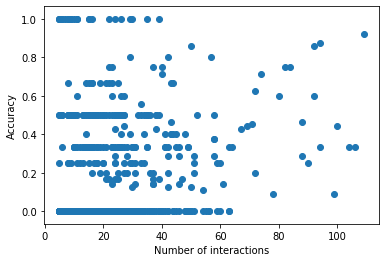

In [152]:
get_user_count_plot_train(UI_tr, UI_ts, rec_bin.predict_K_item_bin, 10, 5)

Plot of accuracy Vs test #likes. Nor here appear a clear relation

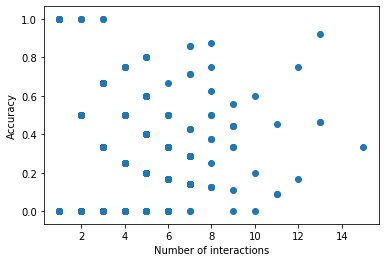

In [154]:
get_user_count_plot_test(UI_tr, UI_ts, rec_bin.predict_K_item_bin, 10, 5)

In [ ]:
scores_bin(score_data_bin, repeat, N_neigh, K, min_rated_restaurants, min_rated_users, ts_size=0.1)

## Experiment4: training the algorithm with test_size = 0.1, over min_like=5. N_neigh from 10 to full data in a grid. Trying to add features

Exploring the users that push several time a button on the same restaurant

In [222]:
n_feat = 3
menu_feat = features_interaction(simple_data_cleaned_filtered, 'menu', n_feat)
full_score_feat_couples  = set(menu_feat.set_index(['restaurant_id','user_id']).index)


These are the users that in Madrid and without outliers are pushing menu n_feat times


In [225]:
len(menu_feat)

79

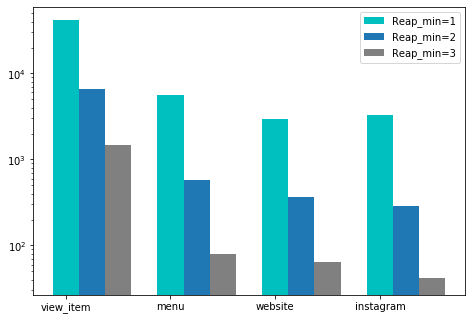

In [246]:
data = [[len(features_interaction(simple_data_cleaned_filtered, 'view_item', 1)), \
         len(features_interaction(simple_data_cleaned_filtered, 'menu', 1)), \
         len(features_interaction(simple_data_cleaned_filtered, 'website', 1)), \
         len(features_interaction(simple_data_cleaned_filtered, 'instagram', 1))],
        [len(features_interaction(simple_data_cleaned_filtered, 'view_item', 2)), \
         len(features_interaction(simple_data_cleaned_filtered, 'menu', 2)), \
         len(features_interaction(simple_data_cleaned_filtered, 'website', 2)), \
         len(features_interaction(simple_data_cleaned_filtered, 'instagram', 2))],
        [len(features_interaction(simple_data_cleaned_filtered, 'view_item', 3)), \
         len(features_interaction(simple_data_cleaned_filtered, 'menu', 3)), \
         len(features_interaction(simple_data_cleaned_filtered, 'website', 3)), \
         len(features_interaction(simple_data_cleaned_filtered, 'instagram', 3))],]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.yscale('log')            # Defines log scale

ax.bar(X + 0.00, data[0], color = 'c', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'tab:blue', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'grey', width = 0.25)
ax.legend(labels=['Reap_min=1', 'Reap_min=2', 'Reap_min=3'])
plt.xticks(X, ['view_item', 'menu', 'website', 'instagram'])

plt.savefig('TFM_figures/Repeated_Actions.jpg', dpi=300, bbox_inches="tight")


Checking if the users in score_feat are the ones in score_bin + the ones in menu_feat dropping the duplicates and the not in users and not in restaurants:

In [210]:
score_feat = add_features_bin(score_bin, simple_data_cleaned_filtered, ['menu'], 2)

score_bin_couples = set(score_bin.set_index(['restaurant_id','user_id']).index)
score_feat_couples = set(score_feat.set_index(['restaurant_id','user_id']).index)

full_feat_bin = set(full_score_feat_couples.union(score_bin_couples))

not_in_user_rest = full_feat_bin - score_feat_couples

#check if score_feat_couples-full_feat_bin is empty 
score_feat_couples-full_feat_bin == set()

True

In [211]:
zipped = list(not_in_user_rest)
unzipped_object = zip(*zipped)
unzipped_list = list(unzipped_object)
not_in_user_set = set(unzipped_list[1])
score_bin_users = set(score_bin.user_id)
not_in_user_set.intersection(score_bin_users) == set()

True

Exploring a train_feat set statistics


In [123]:
np.random.seed(3)
n_feat = 1

#We split the score_bin dataset
train, test = train_test_split(score_bin, test_size=0.1)

#We take the user and restaurants with more then 5
count_train_usr  = train.groupby('user_id')['is_positive'].sum()
count_train_rest = train.groupby('restaurant_id')['is_positive'].sum()
usr_to_take = count_train_usr[count_train_usr>=5].index
rst_to_take = count_train_rest[count_train_rest>=5].index

#We add the features to the train set
train_feat = add_features_bin(train, simple_data_cleaned_filtered, ['menu', 'website', 'instagram'], min_count_feat=n_feat)

#We train the model filtering the users with features that have more then five likes
UI_tr_feat = get_User_Items_bin(train_feat, min_rated_restaurants=1, min_rated_users=1)
UI_tr_feat = UI_tr_feat.loc[usr_to_take,rst_to_take]


In [124]:
#My train_feat set statistics
string = 'There are {} users.\n..\n{} interactions.\n..\n{}'.format(len(UI_tr_feat.index), UI_tr_feat.sum(axis=1).sum(), UI_tr_feat.sum(axis=1).describe())
print(string)


There are 1374 users.
..
24637 interactions.
..
count    1374.000000
mean       17.930859
std        14.689018
min         5.000000
25%         8.000000
50%        13.000000
75%        23.000000
max       110.000000
dtype: float64


#### The scores of the model for experiment 4, over a grid of all the buttons' combinations and Reap_min=1:3

In [213]:
def scores_bin_feat(score_data_bin, repeat, feat_to_add, N_neigh, n_feat, K, min_rated_restaurants, min_rated_users, ts_size=0.1):
    
    tot_scores=[]
    for i in range(repeat): 
        train, test = train_test_split(score_bin, test_size=0.1)

        #We take the user and restaurants with more then 5
        count_train_usr  = train.groupby('user_id')['is_positive'].sum()
        count_train_rest = train.groupby('restaurant_id')['is_positive'].sum()
        usr_to_take = count_train_usr[count_train_usr>=min_rated_restaurants].index
        rst_to_take = count_train_rest[count_train_rest>=min_rated_users].index

        #We add the features to the train set
        train_feat = add_features_bin(train, simple_data_cleaned_filtered, feat_to_add, min_count_feat=n_feat)

       #We train the model filtering the users with features that have more then five likes
        UI_tr_feat = get_User_Items_bin(train_feat, min_rated_restaurants=1, min_rated_users=1)
        UI_tr_feat = UI_tr_feat.loc[usr_to_take,rst_to_take]
        UI_ts = get_User_Items_bin(test)
    
        rec_bin = CollaborativeFiltering(UI_tr_feat, cosine_similarity)
        rec_bin.fit_items_bin()
        tot_scores.append(mean_prec_recall_at_k_bin(UI_tr_feat, UI_ts, rec_bin.predict_K_item_bin, N_neigh, K))
    
    mean_scores  = [sum(y) / len(y) for y in zip(*tot_scores)]
    sigma_acc = np.sqrt(sum([(i[0]-mean_scores[0])**2 for i in tot_scores])/5)

    return mean_scores, sigma_acc  


In [214]:
all_string=['view_item', 'menu', 'website', 'instagram']

all_combo = [list(i) for i in list(combinations(all_string,1))]
for j in range(2,5):
    for i in combinations(all_string,j): 
        all_combo.append(list(i))  

grid_scores = pd.DataFrame(columns=['accuracy','sigma_acc','p@k','r@k','Tested_Ratio', 'feats', 'min_rated'])

idx = 0
for min_count in range(1, 4):
    for combo in all_combo:
        print(combo, min_count)
        scores,sigma_acc=scores_bin_feat(score_data_bin=score_bin, repeat=5, feat_to_add=combo, N_neigh=10, \
                                              n_feat=min_count, K=5, min_rated_restaurants=5, min_rated_users=5, \
                                              ts_size=0.1)

        
        grid_scores.loc[idx,'p@k']=scores[1];grid_scores.loc[idx,'r@k']=scores[2]
        grid_scores.loc[idx,'Tested_Ratio']=scores[3];grid_scores.loc[idx,'accuracy']=scores[0]
        grid_scores.loc[idx,'feats']=combo;grid_scores.loc[idx,'min_rated']=min_count
        grid_scores.loc[idx,'sigma_acc']=sigma_acc
        idx += 1        

['view_item'] 1
['menu'] 1
['website'] 1
['instagram'] 1
['view_item', 'menu'] 1
['view_item', 'website'] 1
['view_item', 'instagram'] 1
['menu', 'website'] 1
['menu', 'instagram'] 1
['website', 'instagram'] 1
['view_item', 'menu', 'website'] 1
['view_item', 'menu', 'instagram'] 1
['view_item', 'website', 'instagram'] 1
['menu', 'website', 'instagram'] 1
['view_item', 'menu', 'website', 'instagram'] 1
['view_item'] 2
['menu'] 2
['website'] 2
['instagram'] 2
['view_item', 'menu'] 2
['view_item', 'website'] 2
['view_item', 'instagram'] 2
['menu', 'website'] 2
['menu', 'instagram'] 2
['website', 'instagram'] 2
['view_item', 'menu', 'website'] 2
['view_item', 'menu', 'instagram'] 2
['view_item', 'website', 'instagram'] 2
['menu', 'website', 'instagram'] 2
['view_item', 'menu', 'website', 'instagram'] 2
['view_item'] 3
['menu'] 3
['website'] 3
['instagram'] 3
['view_item', 'menu'] 3
['view_item', 'website'] 3
['view_item', 'instagram'] 3
['menu', 'website'] 3
['menu', 'instagram'] 3
['websi

In [215]:
best_acc = grid_scores['accuracy'].sort_values(ascending=False).index[0]


The best accuracy is for menu & website button for reap_min=3

In [216]:
grid_scores.loc[best_acc,:]

accuracy               0.130592
sigma_acc             0.0038522
p@k                    0.117149
r@k                    0.229846
Tested_Ratio           0.686481
feats           [menu, website]
min_rated                     3
Name: 37, dtype: object

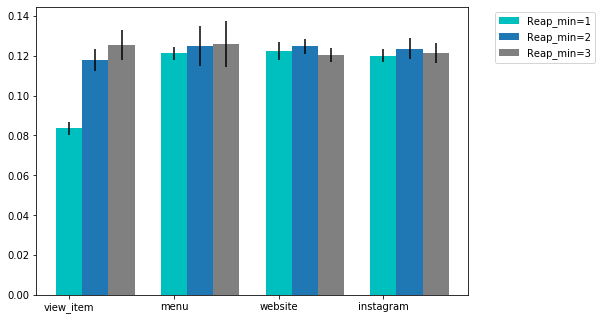

In [271]:
data = [[grid_scores.accuracy[0], \
         grid_scores.accuracy[1], \
         grid_scores.accuracy[2], \
         grid_scores.accuracy[3]],
        [grid_scores.accuracy[15], \
         grid_scores.accuracy[16], \
         grid_scores.accuracy[17], \
         grid_scores.accuracy[18]],
        [grid_scores.accuracy[30], \
         grid_scores.accuracy[31], \
         grid_scores.accuracy[32], \
         grid_scores.accuracy[33]],]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, data[0], color = 'c', width = 0.25, yerr=grid_scores.sigma_acc[:4].values)
ax.bar(X + 0.25, data[1], color = 'tab:blue', width = 0.25, yerr=grid_scores.sigma_acc[15:19].values)
ax.bar(X + 0.50, data[2], color = 'grey', width = 0.25, yerr=grid_scores.sigma_acc[30:34].values)
ax.legend(labels=['Reap_min=1', 'Reap_min=2', 'Reap_min=3'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(X, ['view_item', 'menu', 'website', 'instagram'])

plt.savefig('TFM_figures/Accuracy_Feats.jpg', dpi=300, bbox_inches="tight")

In [252]:
grid_scores['view_item'] = [True if 'view_item' in val else False for val in grid_scores.feats]
grid_scores['menu'] = [True if 'menu' in val else False for val in grid_scores.feats]
grid_scores['website'] = [True if 'website' in val else False for val in grid_scores.feats]
grid_scores['instagram'] = [True if 'instagram' in val else False for val in grid_scores.feats]


In [283]:
grid_scores[grid_scores.view_item==True].accuracy.mean()
grid_scores[grid_scores.menu==True].accuracy.mean()
grid_scores[grid_scores.website==True].accuracy.mean()
grid_scores[grid_scores.instagram==True].accuracy.mean()

0.11565703947438244

### Inspecting a train sample we can see that the best result does not carrie much more informations then binary model

In [169]:
np.random.seed(3)
n_feat = 3

#We split the score_bin dataset
train, test = train_test_split(score_bin, test_size=0.1)

#We take the user and restaurants with more then 5
count_train_usr  = train.groupby('user_id')['is_positive'].sum()
count_train_rest = train.groupby('restaurant_id')['is_positive'].sum()
usr_to_take = count_train_usr[count_train_usr>=5].index
rst_to_take = count_train_rest[count_train_rest>=5].index

#We add the features to the train set
train_feat = add_features_bin(train, simple_data_cleaned_filtered, ['website', 'instagram'], min_count_feat=n_feat)

#We train the model filtering the users with features that have more then five likes
UI_tr_feat = get_User_Items_bin(train_feat, min_rated_restaurants=1, min_rated_users=1)
UI_tr_feat = UI_tr_feat.loc[usr_to_take,rst_to_take]

#My train_feat set statistics
string = 'There are {} users.\n..\n{} interactions.\n..\n{}'.format(len(UI_tr_feat.index), UI_tr_feat.sum(axis=1).sum(), UI_tr_feat.sum(axis=1).describe())
print(string)

There are 1374 users.
..
22000 interactions.
..
count    1374.000000
mean       16.011645
std        14.424776
min         5.000000
25%         7.000000
50%        11.000000
75%        20.000000
max       109.000000
dtype: float64


## Experiment4: training the algorithm with test_size = 0.1, over min_like=5. N_neigh=10. Inspecting time evolution

In [24]:
from datetime import date

data_full['date'] = pd.to_datetime(data_full['event_timestamp'], unit='us').dt.date
end   = list(data_full['date'].sort_values(ascending=False))[0]
start = list(data_full['date'].sort_values(ascending=False))[-1]
start, end

(datetime.date(2021, 3, 1), datetime.date(2021, 4, 30))

### Two weeks data

In [25]:
two_weeks = date(2021,3,14)
two_weeks_data = data_full[data_full['date']<=two_weeks]
two_weeks_data.shape

(56751, 10)

In [34]:
Score_Rules=[]
pre_2w = PreProcessing_Data(two_weeks_data, restaurants_df, Score_Rules)
pre_2w.init_simple_data()
pre_2w.simple_data.copy()
pre_2w.clean_anomalies(10, 1000)
pre_2w.simple_data.copy()
pre_2w.filter_data_for_collaborative()
pre_2w.simple_data.copy()
pre_2w.fit_data_score_bin()

In [51]:
pre_2w.fit_User_Items_bin(5,5)
print('The number of madrid users after 2 weeks with almost five like are {}'.format(len(set(pre_2w.User_Items_bin.index))))
'The number of likes after two weeks, with almost five likes users is {}'.format(pre_2w.User_Items_bin.sum().sum())


The number of madrid users after 2 weeks with almost five like are 205


'The number of likes after two weeks, with almost five likes users is 3243'

In [28]:
def scores_bin(score_data_bin, repeat, N_neigh, K, min_rated_restaurants, min_rated_users, ts_size=0.1):
    
    tot_scores=[]
    for i in range(repeat): 
        train, test = train_test_split(score_data_bin, test_size=ts_size)
        UI_tr = get_User_Items_bin(train, min_rated_restaurants, min_rated_users)
        UI_ts = get_User_Items_bin(test)
    
        rec_bin = CollaborativeFiltering(UI_tr, cosine_similarity)
        rec_bin.fit_items_bin()
        tot_scores.append(mean_prec_recall_at_k_bin(UI_tr, UI_ts, rec_bin.predict_K_item_bin, N_neigh, K))
    #mean_scores = [sum(y) / len(y) for y in zip(*tot_scores)]
    
    return tot_scores 

In [29]:
np.random.seed(3)
#I kept the train and test data from score_bin data frame
train, test = train_test_split(pre_2w.score_data_bin, test_size=0.1)
#I took just the users and restaurants with at least 5 "like"
UI_tr = get_User_Items_bin(train, 5, 5)
UI_ts = get_User_Items_bin(test)
    
rec_bin = CollaborativeFiltering(UI_tr, cosine_similarity)
rec_bin.fit_items_bin()

A sample train set statistics


In [31]:
string = 'There are {} users.\n..\n{} likes.\n..\n{}'.format(len(UI_tr.index), UI_tr.sum(axis=1).sum(), UI_tr.sum(axis=1).describe())
print(string)

There are 196 users.
..
2887 likes.
..
count    196.000000
mean      14.729592
std       12.859531
min        4.000000
25%        7.000000
50%       10.000000
75%       18.000000
max       89.000000
dtype: float64


A sample test set statistics


In [32]:
#My train set statistics
string = 'There are {} users.\n..\n{} likes.\n..\n{}'.format(len(UI_ts.index), UI_ts.sum(axis=1).sum(), UI_ts.sum(axis=1).describe())
print(string)

There are 181 users.
..
376 likes.
..
count    181.000000
mean       2.077348
std        1.600203
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       10.000000
dtype: float64


#### The performances after two weeks

In [181]:
scores_2w = scores_bin(pre_2w.score_data_bin, 5, 10, 5, 5, 5, ts_size=0.1)

In [182]:
mean_scores_2w = [sum(y) / len(y) for y in zip(*scores_2w)]
sigma_scores_2w = sum([(i[0]-mean_scores_2w[0])**2 for i in scores_2w])/5
mean_scores_2w, np.sqrt(sigma_scores_2w)

([0.09604502801487072,
  0.10000746562086764,
  0.1868691786304934,
  0.659838201999006],
 0.013425136962571891)

### Four weeks data

In [47]:
four_weeks = date(2021,3,28)
four_weeks = data_full[data_full['date']<=four_weeks]
four_weeks.shape

(146743, 10)

In [48]:
Score_Rules=[]
pre_4w = PreProcessing_Data(four_weeks, restaurants_df, Score_Rules)
pre_4w.init_simple_data()
pre_4w.simple_data.copy()
pre_4w.clean_anomalies(10, 1000)
pre_4w.simple_data.copy()
pre_4w.filter_data_for_collaborative()
pre_4w.simple_data.copy()
pre_4w.fit_data_score_bin()

In [50]:
pre_4w.fit_User_Items_bin(5,5)

In [53]:
pre_4w.fit_User_Items_bin(5,5)
print('The number of madrid users after 4 weeks with almost five like are {}'.format(len(set(pre_4w.User_Items_bin.index))))
'The number of likes after 4 weeks, with almost five likes users is {}'.format(pre_4w.User_Items_bin.sum().sum())


The number of madrid users after 4 weeks with almost five like are 532


'The number of likes after 4 weeks, with almost five likes users is 8496'

#### The performances after four weeks

In [123]:
scores_4w = scores_bin(pre_4w.score_data_bin, 5, 10, 5, 5, 5, ts_size=0.1)

In [161]:
mean_scores_4w = [sum(y) / len(y) for y in zip(*scores_4w)]
sigma_scores_4w = sum([(i[0]-mean_scores_4w[0])**2 for i in scores_4w])/5

mean_scores_4w, np.sqrt(sigma_scores_4w)

([0.11173587078963207,
  0.11206169661610557,
  0.21891807864904464,
  0.6714778838927656],
 0.007001928190837699)

### Six weeks data

In [54]:
six_weeks = date(2021,4,11)
six_weeks = data_full[data_full['date']<=six_weeks]
six_weeks.shape

Score_Rules=[]
pre_6w = PreProcessing_Data(six_weeks, restaurants_df, Score_Rules)
pre_6w.init_simple_data()
pre_6w.simple_data.copy()
pre_6w.clean_anomalies(10, 1000)
pre_6w.simple_data.copy()
pre_6w.filter_data_for_collaborative()
pre_6w.simple_data.copy()
pre_6w.fit_data_score_bin()


In [55]:
pre_6w.fit_User_Items_bin(5,5)
print('The number of madrid users after 6 weeks with almost five like are {}'.format(len(set(pre_6w.User_Items_bin.index))))
'The number of likes after 6 weeks, with almost five likes users is {}'.format(pre_6w.User_Items_bin.sum().sum())


The number of madrid users after 6 weeks with almost five like are 858


'The number of likes after 6 weeks, with almost five likes users is 13808'

#### The performances after six weeks

In [195]:
scores_6w = scores_bin(pre_6w.score_data_bin, 5, 10, 5, 5, 5, ts_size=0.1)
mean_scores_6w = [sum(y) / len(y) for y in zip(*scores_6w)]
sigma_scores_6w = sum([(i[0]-mean_scores_6w[0])**2 for i in scores_6w])/5
mean_scores_6w, np.sqrt(sigma_scores_6w)

([0.12040873229944185,
  0.11199416234912007,
  0.2270561128533753,
  0.6759229724410043],
 0.007232359599764038)

### Eight weeks data


In [57]:
eight_weeks = date(2021,4,25)
eight_weeks = data_full[data_full['date']<=eight_weeks]

Score_Rules=[]
pre_8w = PreProcessing_Data(eight_weeks, restaurants_df, Score_Rules)
pre_8w.init_simple_data()
pre_8w.simple_data.copy()
pre_8w.clean_anomalies(10, 1000)
pre_8w.simple_data.copy()
pre_8w.filter_data_for_collaborative()
pre_8w.simple_data.copy()
pre_8w.fit_data_score_bin()

pre_8w.fit_User_Items_bin(5,5)
print('The number of madrid users after 8 weeks with almost five like are {}'.format(len(set(pre_8w.User_Items_bin.index))))
'The number of likes after 8 weeks, with almost five likes users is {}'.format(pre_8w.User_Items_bin.sum().sum())


The number of madrid users after 8 weeks with almost five like are 1347


'The number of likes after 8 weeks, with almost five likes users is 22855'

In [ ]:
eight_weeks = date(2021,4,25)
eight_weeks = data_full[data_full['date']<=eight_weeks]

Score_Rules=[]
pre_8w = PreProcessing_Data(eight_weeks, restaurants_df, Score_Rules)
pre_8w.init_simple_data()
pre_8w.simple_data.copy()
pre_8w.clean_anomalies(10, 1000)
pre_8w.simple_data.copy()
pre_8w.filter_data_for_collaborative()
pre_8w.simple_data.copy()
pre_8w.fit_data_score_bin()

scores_bin(pre_8w.score_data_bin, 5, 10, 5, 5, 5, ts_size=0.1)

#### The performances after eight weeks

In [164]:
#scores_8w = scores_bin(pre_8w.score_data_bin, 5, 10, 5, 5, 5, ts_size=0.1)
mean_scores_8w = [sum(y) / len(y) for y in zip(*scores_8w)]
sigma_scores_8w = sum([(i[0]-mean_scores_8w[0])**2 for i in scores_8w])/5

mean_scores_8w, np.sqrt(sigma_scores_8w)

([0.11556510760707508,
  0.11102185569832819,
  0.21885097827921948,
  0.6765047525144776],
 0.009116105466535513)

#### The performances after ten weeks

In [165]:
scores_10w = scores_bin(score_bin, 5, 10, 5, 5, 5, ts_size=0.1)
mean_scores_10w = [sum(y) / len(y) for y in zip(*scores_10w)]
sigma_scores_10w = sum([(i[0]-mean_scores_10w[0])**2 for i in scores_10w])/5
mean_scores_10w, np.sqrt(sigma_scores_10w)

([0.12709452830096307,
  0.11538165382018625,
  0.2222953442916255,
  0.6814829695682955],
 0.006049170573596904)

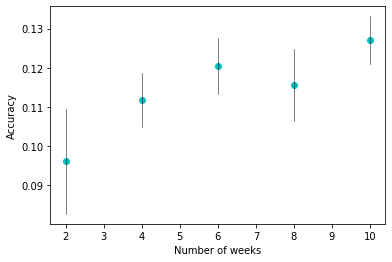

In [196]:
means_w = [mean_scores_2w[0], mean_scores_4w[0], mean_scores_6w[0], mean_scores_8w[0], mean_scores_10w[0]]
weeks = [2 ,4 ,6 ,8 ,10]

plt.plot(weeks, means_w, 'o', color='c')
plt.plot([2,2], [mean_scores_2w[0]-np.sqrt(sigma_scores_2w), mean_scores_2w[0]+np.sqrt(sigma_scores_2w)], 'k-', lw=.5)
plt.plot([4,4], [mean_scores_4w[0]-np.sqrt(sigma_scores_4w), mean_scores_4w[0]+np.sqrt(sigma_scores_4w)], 'k-', lw=.5)
plt.plot([6,6], [mean_scores_6w[0]-np.sqrt(sigma_scores_6w), mean_scores_6w[0]+np.sqrt(sigma_scores_6w)], 'k-', lw=.5)
plt.plot([8,8], [mean_scores_8w[0]-np.sqrt(sigma_scores_8w), mean_scores_8w[0]+np.sqrt(sigma_scores_8w)], 'k-', lw=.5)
plt.plot([10,10], [mean_scores_10w[0]-np.sqrt(sigma_scores_10w), mean_scores_10w[0]+np.sqrt(sigma_scores_10w)], 'k-', lw=.5)

plt.ylabel('Accuracy')
plt.xlabel('Number of weeks')

plt.savefig('TFM_figures/Acc_Vs_Number_of_weeks.jpg', dpi=300, bbox_inches="tight")



### Active users

In [64]:
def get_usr_activity_df(data_full):
    
    pseudo_id_set = set(data_full.user_pseudo_id)
    activity_df = pd.DataFrame(index=list(pseudo_id_set), columns=['delta', 'differents_days_activity'])

    for pseudo_id in pseudo_id_set:
        
        usr_dates = data_full[data_full.user_pseudo_id==pseudo_id].date.sort_values(ascending=False)
        delta = usr_dates.iloc[0]-usr_dates.iloc[len(usr_dates)-1]
        activity_df.loc[pseudo_id,'delta']=delta
        activity_df.loc[pseudo_id,'differents_days_activity']=len(usr_dates.unique())
    return activity_df


In [65]:
activity_df = get_usr_activity_df(data_full)
activity_df

,pseudo_id,delta,differents_days_activity
A5AC5F8520D04B629F911D4ACF2036DB,NaN,0:00:00,1
F5D29668FF55410DBA37D134202BF0F8,NaN,"11 days, 0:00:00",3
a87fe5e0b30f6af3c02462008c668c44,NaN,0:00:00,1
59b20ba83434d1ed0276c1ca7c65a6e6,NaN,0:00:00,1
d48fe374c1b10d5a9f1356f6c7863202,NaN,"5 days, 0:00:00",5
...,...,...,...
1eb3123d45a3fa401c37b35e1e131d25,NaN,0:00:00,1
d1cbdf3a80d886ab0c3705f827b149c5,NaN,0:00:00,1
61ACFB6C76AA450280E7195A595101C5,NaN,0:00:00,1
203EBE8734024EC8AF9031E3F7554A4C,NaN,0:00:00,1


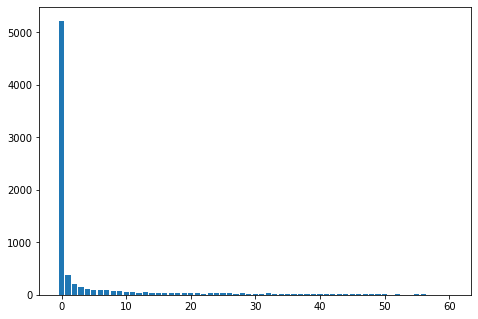

In [89]:
frequency = activity_df.delta.value_counts()

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
days = [i.days for i in frequency.index]
freq = frequency.values
ax.bar(days,freq)
plt.show()

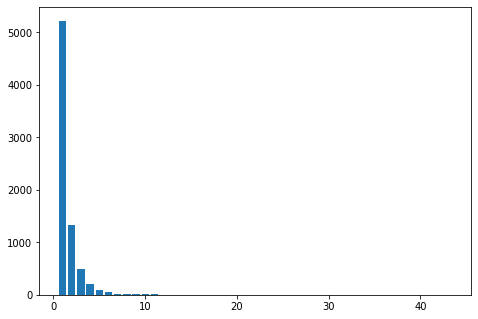

In [90]:
frequency = activity_df.differents_days_activity.value_counts()

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
days = frequency.index
freq = frequency.values
ax.bar(days,freq)
plt.show()